In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood

# Make plots inline
%matplotlib inline

# 1 Read Data

In [3]:
#read the data and create data frame
df = pd.read_csv('heart_rate_data.csv')
df['time'] = np.linspace(0, 900, len(df))
df.columns = ['Y','time']
df

,Y,time
0,84.2697,0.000000
1,84.0619,0.500556
2,85.6542,1.001112
3,87.2093,1.501669
4,87.1246,2.002225
...,...,...
1794,103.7900,897.997775
1795,101.6230,898.498331
1796,99.5679,898.998888
1797,99.1835,899.499444


In [4]:
train_size = 150 #at the head
test_size = 100 #in the middle
train_size2 = 150 #at the tail
split = train_size + test_size + train_size2

#get training set
train = df[0:train_size].append(df[train_size + test_size:split]) 
X_train_ = np.array(train['time'])
Y_train_ = np.array(train['Y'])

#get testing set
test = df[train_size-1:train_size+test_size+1]
X_test_ = np.array(test['time'])
Y_test_ = np.array(test['Y'])

# Below df are only used for poltting the data
# we add nan in between 2 parts of training data to avoid the straight line between twp training set in later plotting
df_train_two_side = df.copy(deep=True)
df_train_two_side['Y'][train_size:train_size+test_size] = np.nan
train_2_side = df_train_two_side[0:split]
X_train_with_nan_ = np.array(train_2_side['time'])
Y_train_with_nan_ = np.array(train_2_side['Y'])  

/var/folders/ts/xc6_h0kd5nv7gws_x4n04jwr0000gn/T/ipykernel_19223/3002064789.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = df[0:train_size].append(df[train_size + test_size:split])


In [5]:
#make data into tensor format
X_train = torch.tensor(X_train_)
Y_train = torch.tensor(Y_train_)

X_test = torch.tensor(X_test_)
Y_test = torch.tensor(Y_test_)

X_train_with_nan = torch.tensor(X_train_with_nan_)
Y_train_with_nan = torch.tensor(Y_train_with_nan_) 

# 2 Implement Model with GpyTorch

In [5]:
#import the self-design kernel from gpytorch_design_kernel
from GpyTorch_custom_kernel import FirstSincKernel

## 2.1 Model 1: RBF

In [6]:
class GPRegressionModel_1(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_1, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that. 
        # Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). 
        # Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        #we are going to warpping below kernel inside the interpolation kernel
        self.base_kernel = gpytorch.kernels.RBFKernel() 

        #Exp-Sine-Squared kernel (aka periodic kernel)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                self.base_kernel, grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood_1 = gpytorch.likelihoods.GaussianLikelihood()
model_1 = GPRegressionModel_1(X_train, Y_train, likelihood_1)

if torch.cuda.is_available():
    model_1 = model_1.cuda()
    likelihood_1 = likelihood_1.cuda()

In [7]:
training_iterations =  300

start_time = time.time()

# Find optimal model hyperparameters
model_1.train()
likelihood_1.train()

# Use the adam optimizer
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_1, model_1)

train_losses = []
test_losses = []

for epoch in range(training_iterations):
    #get train loss for this iter
    model_1.train()
    likelihood_1.train()
    optimizer_1.zero_grad()
    train_predition = model_1(X_train)
    train_loss = -mll(train_predition, Y_train)
    train_losses.append(train_loss)
    train_loss.backward()
    optimizer_1.step()

    #get test loss for this iter
    model_1.eval()
    with torch.no_grad():
        untrained_pred_dist = likelihood_1(model_1(X_test))
        predictive_mean = untrained_pred_dist.mean
        lower, upper = untrained_pred_dist.confidence_region()
        #here we use mse instead of marginal log likelihood because 
        #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
        test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
        test_losses.append(test_mse)

end_time = time.time()

train_losses = [float(i) for i in train_losses]
test_losses = [float(i) for i in test_losses]
print('tesing MSE after', training_iterations, 'epochs:', test_losses[-1])
print('training time for', training_iterations, 'epochs:', end_time - start_time)

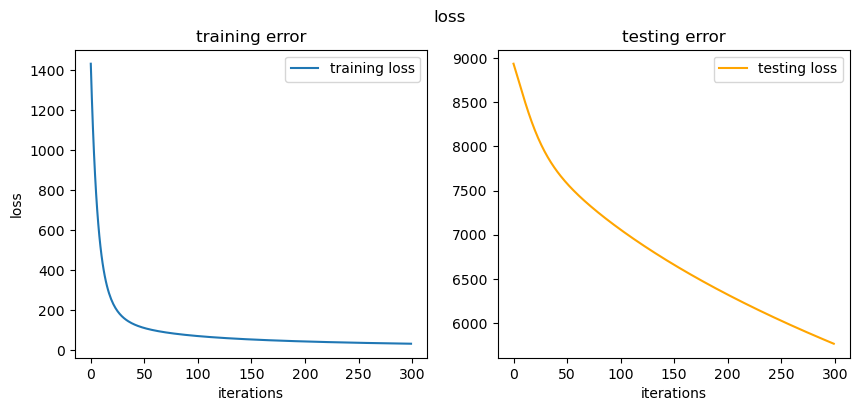

In [ ]:
#plot loss log
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('loss')
axs[0].plot(train_losses, label = 'training loss')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('loss')
axs[0].set_title('training error')
axs[0].legend()

axs[1].set_xlabel('iterations')
axs[1].plot(test_losses, label = 'testing loss', c = 'orange')
axs[1].set_title('testing error')
axs[1].legend()

In [9]:
# Put model & likelihood into eval mode
model_1.eval()
likelihood_1.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_prediction = likelihood_1(model_1(X_train))
    train_mean = train_prediction.mean
    test_prediction = likelihood_1(model_1(X_test))
    test_mean = test_prediction.mean
    train_lower, train_upper = train_prediction.confidence_region()
    test_lower, test_upper = test_prediction.confidence_region()

#add nan in the middle of testing prediction, use for later plotting
y_pred_train_with_nan = d = np.concatenate((np.array(train_mean[0:train_size])\
    , np.array([np.nan for i in range(test_size)]), np.array(train_mean[train_size:]))) 
y_pred_test = np.array(test_mean)

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


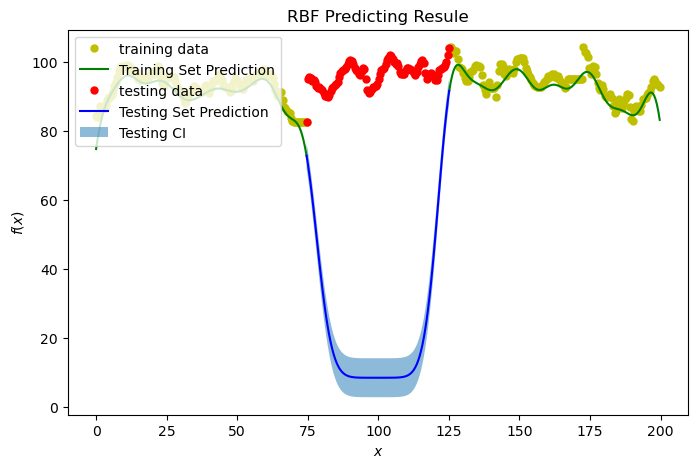

In [13]:
plt.figure(figsize=(8,5))
plt.plot(X_train_with_nan, Y_train_with_nan, 'y.', markersize=10, label='training data') #plot training data
plt.plot(X_train_with_nan, y_pred_train_with_nan, 'g-', label='Training Set Prediction') # plot training prediction
plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data') #plot testing data
plt.plot(X_test, y_pred_test, 'b-', label='Testing Set Prediction') #plot testing prediction
plt.fill_between(X_test, test_lower, test_upper, alpha=0.5, label = 'Testing CI') #add CI

plt.title('RBF Predicting Resule')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()

## 2.2 Model 2: Periodic

In [11]:
class GPRegressionModel_2(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_2, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that. 
        # Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). 
        # Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        #we are going to warpping below kernel inside the interpolation kernel
        self.base_kernel = gpytorch.kernels.PeriodicKernel() 

        #Exp-Sine-Squared kernel (aka periodic kernel)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                self.base_kernel, grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood_2 = gpytorch.likelihoods.GaussianLikelihood()
model_2 = GPRegressionModel_2(X_train, Y_train, likelihood_2)

if torch.cuda.is_available():
    model_2 = model_2.cuda()
    likelihood_2 = likelihood_2.cuda()

In [12]:
training_iterations =  300

start_time = time.time()

# Find optimal model hyperparameters
model_2.train()
likelihood_2.train()

# Use the adam optimizer
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_2, model_2)

train_losses = []
test_losses = []

for epoch in range(training_iterations):
    #get train loss for this iter
    model_2.train()
    likelihood_2.train()
    optimizer_2.zero_grad()
    train_predition = model_2(X_train)
    train_loss = -mll(train_predition, Y_train)
    train_losses.append(train_loss)
    train_loss.backward()
    optimizer_2.step()

    #get test loss for this iter
    model_2.eval()
    with torch.no_grad():
        untrained_pred_dist = likelihood_2(model_2(X_test))
        predictive_mean = untrained_pred_dist.mean
        lower, upper = untrained_pred_dist.confidence_region()
        #here we use mse instead of marginal log likelihood because 
        #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
        test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
        test_losses.append(test_mse)

end_time = time.time()

train_losses = [float(i) for i in train_losses]
test_losses = [float(i) for i in test_losses]
print('tesing MSE after', training_iterations, 'epochs:', test_losses[-1])
print('training time for', training_iterations, 'epochs:', end_time - start_time)

tesing MSE after 300 epochs: 21.23498686758063
training time for 300 epochs: 30.061952590942383


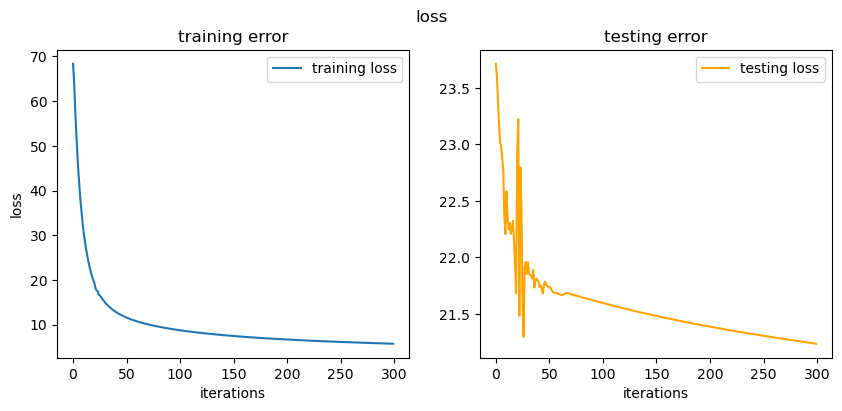

In [14]:
#plot loss log
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('loss')
axs[0].plot(train_losses, label = 'training loss')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('loss')
axs[0].set_title('training error')
axs[0].legend()

axs[1].set_xlabel('iterations')
axs[1].plot(test_losses, label = 'testing loss', c = 'orange')
axs[1].set_title('testing error')
axs[1].legend()

In [15]:
# Put model & likelihood into eval mode
model_2.eval()
likelihood_2.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_prediction = likelihood_2(model_2(X_train))
    train_mean = train_prediction.mean
    test_prediction = likelihood_2(model_2(X_test))
    test_mean = test_prediction.mean
    train_lower, train_upper = train_prediction.confidence_region()
    test_lower, test_upper = test_prediction.confidence_region()

#add nan in the middle of testing prediction, use for later plotting
y_pred_train_with_nan = d = np.concatenate((np.array(train_mean[0:train_size])\
    , np.array([np.nan for i in range(test_size)]), np.array(train_mean[train_size:]))) 
y_pred_test = np.array(test_mean)

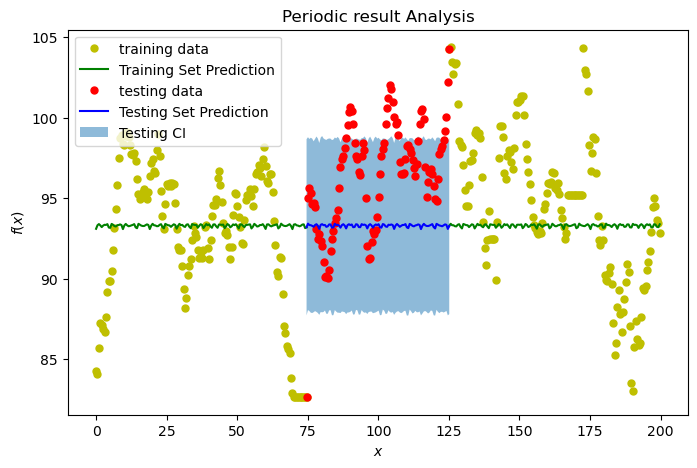

In [16]:
plt.figure(figsize=(8,5))
plt.plot(X_train_with_nan, Y_train_with_nan, 'y.', markersize=10, label='training data') #plot training data
plt.plot(X_train_with_nan, y_pred_train_with_nan, 'g-', label='Training Set Prediction') # plot training prediction
plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data') #plot testing data
plt.plot(X_test, y_pred_test, 'b-', label='Testing Set Prediction') #plot testing prediction
plt.fill_between(X_test, test_lower, test_upper, alpha=0.5, label = 'Testing CI') #add CI

plt.title('Periodic Result Analysis')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()

## 2.3 Model 3: RBF + Periodic

In [17]:
class GPRegressionModel_3(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_3, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that. 
        # Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). 
        # Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        #we are going to warpping below kernel inside the interpolation kernel
        self.base_kernel = gpytorch.kernels.RBFKernel() +  gpytorch.kernels.PeriodicKernel() 

        #Exp-Sine-Squared kernel (aka periodic kernel)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                self.base_kernel, grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood_3 = gpytorch.likelihoods.GaussianLikelihood()
model_3 = GPRegressionModel_3(X_train, Y_train, likelihood_3)

if torch.cuda.is_available():
    model_3 = model_3.cuda()
    likelihood_3 = likelihood_3.cuda()

In [18]:
training_iterations =  500

start_time = time.time()

# Find optimal model hyperparameters
model_3.train()
likelihood_3.train()

# Use the adam optimizer
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_3, model_3)

train_losses = []
test_losses = []

for epoch in range(training_iterations):
    #get train loss for this iter
    model_3.train()
    likelihood_3.train()
    optimizer_3.zero_grad()
    train_predition = model_3(X_train)
    train_loss = -mll(train_predition, Y_train)
    train_losses.append(train_loss)
    train_loss.backward()
    optimizer_3.step()

    #get test loss for this iter
    model_3.eval()
    with torch.no_grad():
        untrained_pred_dist = likelihood_3(model_3(X_test))
        predictive_mean = untrained_pred_dist.mean
        lower, upper = untrained_pred_dist.confidence_region()
        #here we use mse instead of marginal log likelihood because 
        #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
        test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
        test_losses.append(test_mse)
    
    if epoch == 299:
        end_time = time.time()
        print('training time for', epoch + 1, 'epochs:', end_time - start_time)

end_time = time.time()

train_losses = [float(i) for i in train_losses]
test_losses = [float(i) for i in test_losses]
print('tesing MSE after', 300, 'epochs:', test_losses[300])
print('tesing MSE after', training_iterations, 'epochs:', test_losses[-1])

# Here we use 300 and 500
#300 for the standardized comparison
#500 because this kernel is more complex (300 is not enough for the testing MSE to decrease enough), so we want to give it more time

training time for 300 epochs: 30.956259965896606
tesing MSE after 300 epochs: 59.06494305754477
tesing MSE after 500 epochs: 49.21109799733656


We find that RBF even has an negative influence on the testing result

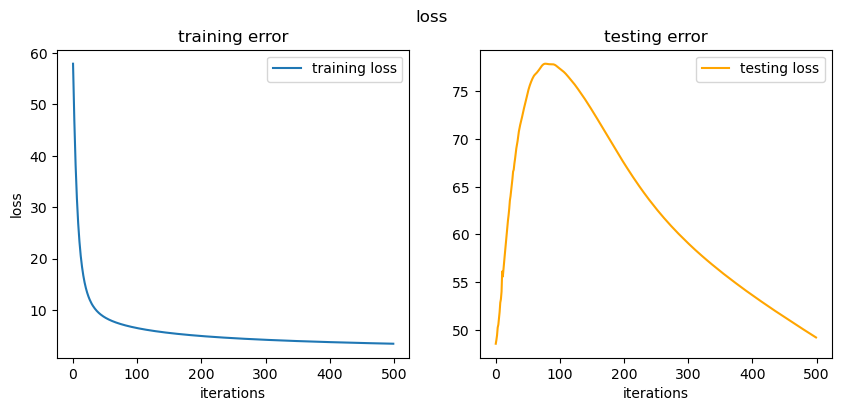

In [19]:
#plot loss log
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('loss')
axs[0].plot(train_losses, label = 'training loss')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('loss')
axs[0].set_title('training error')
axs[0].legend()

axs[1].set_xlabel('iterations')
axs[1].plot(test_losses, label = 'testing loss', c = 'orange')
axs[1].set_title('testing error')
axs[1].legend()

In [20]:
# Put model & likelihood into eval mode
model_3.eval()
likelihood_3.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_prediction = likelihood_3(model_3(X_train))
    train_mean = train_prediction.mean
    test_prediction = likelihood_3(model_3(X_test))
    test_mean = test_prediction.mean
    train_lower, train_upper = train_prediction.confidence_region()
    test_lower, test_upper = test_prediction.confidence_region()

#add nan in the middle of testing prediction, use for later plotting
y_pred_train_with_nan = d = np.concatenate((np.array(train_mean[0:train_size])\
    , np.array([np.nan for i in range(test_size)]), np.array(train_mean[train_size:]))) 
y_pred_test = np.array(test_mean)

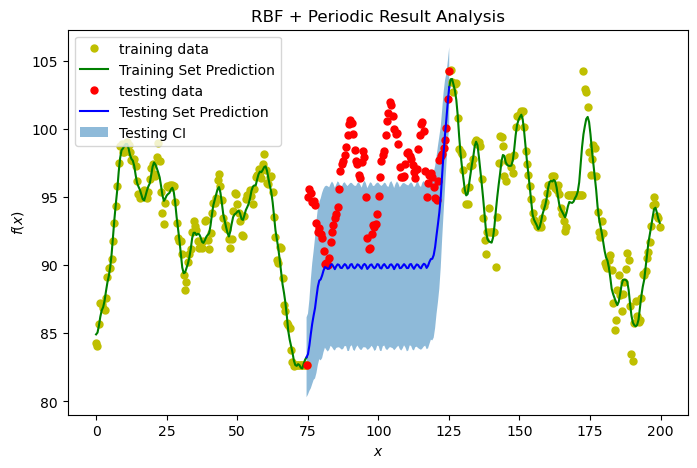

In [21]:
plt.figure(figsize=(8,5))
plt.plot(X_train_with_nan, Y_train_with_nan, 'y.', markersize=10, label='training data') #plot training data
plt.plot(X_train_with_nan, y_pred_train_with_nan, 'g-', label='Training Set Prediction') # plot training prediction
plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data') #plot testing data
plt.plot(X_test, y_pred_test, 'b-', label='Testing Set Prediction') #plot testing prediction
plt.fill_between(X_test, test_lower, test_upper, alpha=0.5, label = 'Testing CI') #add CI

plt.title('RBF + Periodic Result Analysis')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()

RBF + Periodic has better plotting, but worse MSE 

## 2.4 Model 4: Periodic + FixedNoiseGaussianLikelihood

In [10]:
class GPRegressionModel_4(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_4, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that. 
        # Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). 
        # Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        #we are going to warpping below kernel inside the interpolation kernel
        self.base_kernel = gpytorch.kernels.PeriodicKernel()

        #Exp-Sine-Squared kernel (aka periodic kernel)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                self.base_kernel, grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

noise_level = 0.01
likelihood_4 = FixedNoiseGaussianLikelihood(torch.ones(len(X_train))* noise_level)
model_4 = GPRegressionModel_4(X_train, Y_train, likelihood_4)

if torch.cuda.is_available():
    model_4 = model_4.cuda()
    likelihood_4 = likelihood_4.cuda()

### training and plot loss history

In [11]:
training_iterations =  300

start_time = time.time()

# Find optimal model hyperparameters
model_4.train()
likelihood_4.train()

# Use the adam optimizer
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_4, model_4)

train_losses = []
test_losses = []

for epoch in range(training_iterations):
    #get train loss for this iter
    model_4.train()
    likelihood_4.train()
    optimizer_4.zero_grad()
    train_predition = model_4(X_train)
    train_loss = -mll(train_predition, Y_train)
    train_losses.append(train_loss)
    train_loss.backward()
    optimizer_4.step()

    #get test loss for this iter
    model_4.eval()
    with torch.no_grad():
        untrained_pred_dist = likelihood_4(model_4(X_test))
        predictive_mean = untrained_pred_dist.mean
        lower, upper = untrained_pred_dist.confidence_region()
        #here we use mse instead of marginal log likelihood because 
        #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
        test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
        test_losses.append(test_mse)

end_time = time.time()

train_losses = [float(i) for i in train_losses]
test_losses = [float(i) for i in test_losses]
print('tesing MSE after', training_iterations, 'epochs:', test_losses[-1])
print('training time for', training_iterations, 'epochs:', end_time - start_time)

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


tesing MSE after 300 epochs: 19.489798222153155
training time for 300 epochs: 29.684145212173462


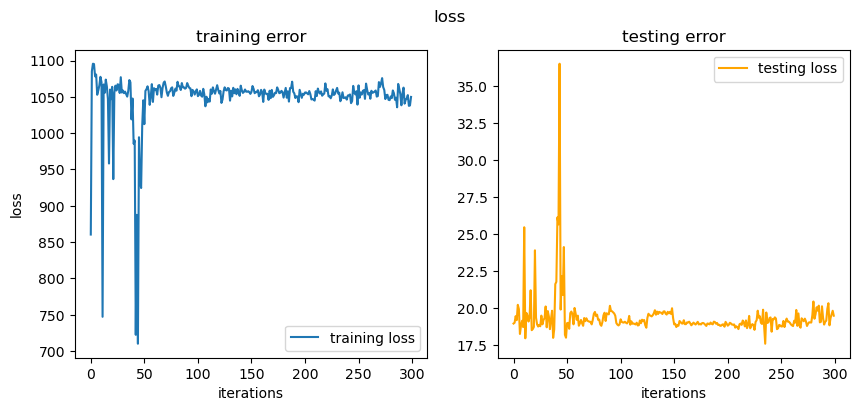

In [12]:
#plot loss log
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('loss')
axs[0].plot(train_losses, label = 'training loss')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('loss')
axs[0].set_title('training error')
axs[0].legend()

axs[1].set_xlabel('iterations')
axs[1].plot(test_losses, label = 'testing loss', c = 'orange')
axs[1].set_title('testing error')
axs[1].legend()

The preditive result is not stable, but better than without FixedNoiseGaussianLikelihood one

In [13]:
# Put model & likelihood into eval mode
model_4.eval()
likelihood_4.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_prediction = likelihood_4(model_4(X_train))
    train_mean = train_prediction.mean
    test_prediction = likelihood_4(model_4(X_test))
    test_mean = test_prediction.mean
    train_lower, train_upper = train_prediction.confidence_region()
    test_lower, test_upper = test_prediction.confidence_region()

#add nan in the middle of testing prediction, use for later plotting
y_pred_train_with_nan = d = np.concatenate((np.array(train_mean[0:train_size])\
    , np.array([np.nan for i in range(test_size)]), np.array(train_mean[train_size:]))) 
y_pred_test = np.array(test_mean)

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


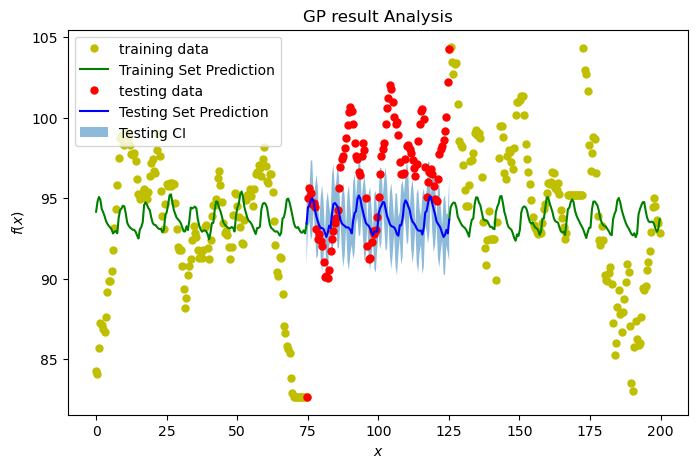

In [14]:
plt.figure(figsize=(8,5))
plt.plot(X_train_with_nan, Y_train_with_nan, 'y.', markersize=10, label='training data') #plot training data
plt.plot(X_train_with_nan, y_pred_train_with_nan, 'g-', label='Training Set Prediction') # plot training prediction
plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data') #plot testing data
plt.plot(X_test, y_pred_test, 'b-', label='Testing Set Prediction') #plot testing prediction
plt.fill_between(X_test, test_lower, test_upper, alpha=0.5, label = 'Testing CI') #add CI

plt.title('GP result Analysis')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()

## 2.5 Analyze what is the best fixed noise level (Periodic)

In [31]:
noise_level_range = np.concatenate((np.arange(0.01, 0.1, 0.03), np.arange(0.1, 1.5, 0.1)), axis = 0)
noise_level_range

array([0.01, 0.04, 0.07, 0.1 , 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 ,
       0.8 , 0.9 , 1.  , 1.1 , 1.2 , 1.3 , 1.4 ])

In [32]:
train_losses = []
test_losses = []

for currrent_noise_level in noise_level_range:
    current_likelihood = FixedNoiseGaussianLikelihood(torch.ones(len(X_train))* currrent_noise_level)
    current_model = GPRegressionModel_4(X_train, Y_train, current_likelihood)
    if torch.cuda.is_available():
        current_model = current_model.cuda()
        current_likelihood = current_likelihood.cuda()
    training_iterations =  120

    # Find optimal model hyperparameters
    current_model.train()
    current_likelihood.train()

    # Use the adam optimizer
    current_optimizer = torch.optim.Adam(current_model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(current_likelihood, current_model)

    for epoch in range(training_iterations):
        #get train loss for this iter
        current_model.train()
        current_likelihood.train()
        current_optimizer.zero_grad()
        train_predition = current_model(X_train)
        train_loss = -mll(train_predition, Y_train)
        train_loss.backward()
        current_optimizer.step()

        #get test loss for this iter
        current_model.eval()
        with torch.no_grad():
            untrained_pred_dist = current_likelihood(current_model(X_test))
            predictive_mean = untrained_pred_dist.mean
            lower, upper = untrained_pred_dist.confidence_region()
            #here we use mse instead of marginal log likelihood because 
            #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
            test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
    
    train_losses.append(train_loss)
    test_losses.append(test_mse)

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


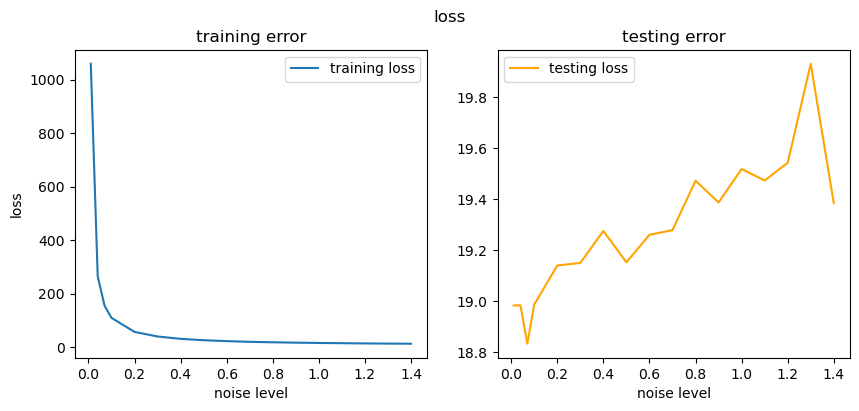

In [35]:
train_losses = [float(i) for i in train_losses]
test_losses = [float(i) for i in test_losses]

#plot loss log
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('loss')
axs[0].plot(noise_level_range, train_losses, label = 'training loss')
axs[0].set_xlabel('noise level')
axs[0].set_ylabel('loss')
axs[0].set_title('training error')
axs[0].legend()

axs[1].set_xlabel('noise level')
axs[1].plot(noise_level_range, test_losses, label = 'testing loss', c = 'orange')
axs[1].set_title('testing error')
axs[1].legend()


0.04 could be a good choice for noise level

## 2.6 Model 6: Periodic + FixedNoiseGaussianLikelihood (with better noise level compared with 2.4)

In [6]:
class GPRegressionModel_6(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_6, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that. 
        # Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). 
        # Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        #we are going to warpping below kernel inside the interpolation kernel
        self.base_kernel = gpytorch.kernels.PeriodicKernel()

        #Exp-Sine-Squared kernel (aka periodic kernel)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                self.base_kernel, grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

noise_level = 0.01
likelihood_6 = FixedNoiseGaussianLikelihood(torch.ones(len(X_train))* noise_level)
model_6 = GPRegressionModel_6(X_train, Y_train, likelihood_6)

if torch.cuda.is_available():
    model_6 = model_6.cuda()
    likelihood_6 = likelihood_6.cuda()

In [7]:
training_iterations =  300

start_time = time.time()

# Find optimal model hyperparameters
model_6.train()
likelihood_6.train()

# Use the adam optimizer
optimizer_6 = torch.optim.Adam(model_6.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_6, model_6)

train_losses = []
test_losses = []

for epoch in range(training_iterations):
    #get train loss for this iter
    model_6.train()
    likelihood_6.train()
    optimizer_6.zero_grad()
    train_predition = model_6(X_train)
    train_loss = -mll(train_predition, Y_train)
    train_losses.append(train_loss)
    train_loss.backward()
    optimizer_6.step()

    #get test loss for this iter
    model_6.eval()
    with torch.no_grad():
        untrained_pred_dist = likelihood_6(model_6(X_test))
        predictive_mean = untrained_pred_dist.mean
        lower, upper = untrained_pred_dist.confidence_region()
        #here we use mse instead of marginal log likelihood because 
        #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
        test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
        test_losses.append(test_mse)

end_time = time.time()

train_losses = [float(i) for i in train_losses]
test_losses = [float(i) for i in test_losses]
print('tesing MSE after', training_iterations, 'epochs:', test_losses[-1])
print('training time for', training_iterations, 'epochs:', end_time - start_time)

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


tesing MSE after 300 epochs: 19.489798222153155
training time for 300 epochs: 31.869560956954956


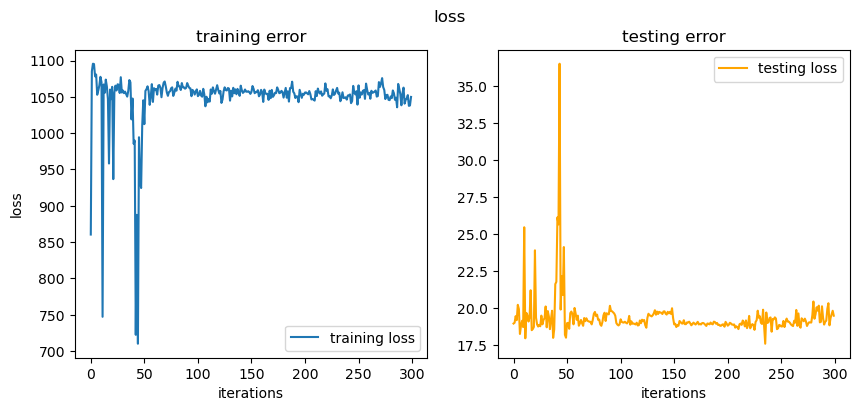

In [8]:
#plot loss log
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('loss')
axs[0].plot(train_losses, label = 'training loss')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('loss')
axs[0].set_title('training error')
axs[0].legend()

axs[1].set_xlabel('iterations')
axs[1].plot(test_losses, label = 'testing loss', c = 'orange')
axs[1].set_title('testing error')
axs[1].legend()

There is no difference with result of model 4, so we just keeep model 4

## 2.7 Periodic + RBF + FixedNoiseLikelyhood

In [22]:
class GPRegressionModel_7(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_7, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that. 
        # Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). 
        # Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        #we are going to warpping below kernel inside the interpolation kernel
        self.base_kernel = gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.RBFKernel()

        #Exp-Sine-Squared kernel (aka periodic kernel)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                self.base_kernel, grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

noise_level = 0.01
likelihood_7 = FixedNoiseGaussianLikelihood(torch.ones(len(X_train))* noise_level)
model_7 = GPRegressionModel_7(X_train, Y_train, likelihood_7)

if torch.cuda.is_available():
    model_7 = model_7.cuda()
    likelihood_7 = likelihood_7.cuda()

In [24]:
training_iterations =  300

start_time = time.time()

# Find optimal model hyperparameters
model_7.train()
likelihood_7.train()

# Use the adam optimizer
optimizer_7 = torch.optim.Adam(model_7.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_7, model_7)

train_losses = []
test_losses = []

for epoch in range(training_iterations):
    #get train loss for this iter
    model_7.train()
    likelihood_7.train()
    optimizer_7.zero_grad()
    train_predition = model_7(X_train)
    train_loss = -mll(train_predition, Y_train)
    train_losses.append(train_loss)
    train_loss.backward()
    optimizer_7.step()

    #get test loss for this iter
    model_7.eval()
    with torch.no_grad():
        untrained_pred_dist = likelihood_7(model_7(X_test))
        predictive_mean = untrained_pred_dist.mean
        lower, upper = untrained_pred_dist.confidence_region()
        #here we use mse instead of marginal log likelihood because 
        #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
        test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
        test_losses.append(test_mse)

end_time = time.time()

train_losses = [float(i) for i in train_losses]
test_losses = [float(i) for i in test_losses]
print('tesing MSE after', training_iterations, 'epochs:', test_losses[-1])
print('training time for', training_iterations, 'epochs:', end_time - start_time)

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


tesing MSE after 300 epochs: 26.11030624780621
training time for 300 epochs: 30.946125030517578


In [25]:
# Put model & likelihood into eval mode
model_7.eval()
likelihood_7.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_prediction = likelihood_7(model_7(X_train))
    train_mean = train_prediction.mean
    test_prediction = likelihood_7(model_7(X_test))
    test_mean = test_prediction.mean
    train_lower, train_upper = train_prediction.confidence_region()
    test_lower, test_upper = test_prediction.confidence_region()

#add nan in the middle of testing prediction, use for later plotting
y_pred_train_with_nan = d = np.concatenate((np.array(train_mean[0:train_size])\
    , np.array([np.nan for i in range(test_size)]), np.array(train_mean[train_size:]))) 
y_pred_test = np.array(test_mean)

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


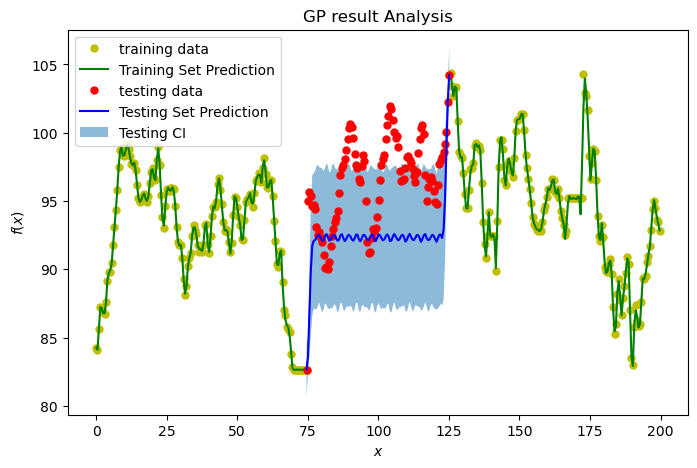

In [26]:
plt.figure(figsize=(8,5))
plt.plot(X_train_with_nan, Y_train_with_nan, 'y.', markersize=10, label='training data') #plot training data
plt.plot(X_train_with_nan, y_pred_train_with_nan, 'g-', label='Training Set Prediction') # plot training prediction
plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data') #plot testing data
plt.plot(X_test, y_pred_test, 'b-', label='Testing Set Prediction') #plot testing prediction
plt.fill_between(X_test, test_lower, test_upper, alpha=0.5, label = 'Testing CI') #add CI

plt.title('GP result Analysis')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()

## 2.8 Deep Model (Periodic + RBF + FixedNoiseLikelyhood) But no interpolation

In [6]:
# In this section, we use below data format to prevent bug
X_train_8 = np.array(train['time']).reshape(-1,1)
X_train_8 = torch.tensor(X_train_8).float()
Y_train_8 = np.array(train['Y']).reshape(-1,1)
Y_train_8 = torch.tensor(Y_train_8).float().flatten()
X_test_8 = np.array(test['time']).reshape(-1,1)
X_test_8 = torch.tensor(X_test_8).float().flatten()

Y_test_8 = np.array(test['Y']).reshape(-1,1)
Y_test_8 = torch.tensor(Y_test_8).float().flatten()

In [7]:
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self, input_dim):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(input_dim, 80))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(80, 60))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(60, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, 2))

In [8]:
class GPRegressionModel_8(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_8, self).__init__(train_x, train_y, likelihood)

        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        #we are going to warpping below kernel inside the interpolation kernel
        self.base_kernel = gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.RBFKernel() 

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.RBFKernel())

        # self.covar_module = gpytorch.kernels.ScaleKernel(
        #     gpytorch.kernels.GridInterpolationKernel(
        # self.base_kernel, grid_size=grid_size, num_dims=1
        #     )
        # )

        self.feature_extractor = LargeFeatureExtractor(input_dim=train_x.size(-1))

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        # We're also scaling the features so that they're nice values
        projected_x = self.feature_extractor(x)
        projected_x = projected_x - projected_x.min(0)[0]
        projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

        # The rest of this looks like what we've seen
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood_8 = FixedNoiseGaussianLikelihood(torch.ones(len(X_train_8)) * 0.01)
###likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood.noise_covar.noise = 1
model_8 = GPRegressionModel_8(X_train_8, Y_train_8, likelihood_8)

if torch.cuda.is_available():

    model_8 = model_8.cuda()
    likelihood_8 = likelihood_8.cuda()

Strange: In the below block, when training epoch is 400, the result degenerate


In [9]:
training_iterations =  

start_time = time.time()

# Find optimal model hyperparameters
model_8.train()
likelihood_8.train()

# Use the adam optimizer
optimizer_8 = torch.optim.Adam(model_8.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_8, model_8)

train_losses = []
test_losses = []

for epoch in range(training_iterations):
    #get train loss for this iter
    model_8.train()
    likelihood_8.train()
    optimizer_8.zero_grad()
    train_predition = model_8(X_train_8)
    train_loss = -mll(train_predition, Y_train_8)
    train_losses.append(train_loss)
    train_loss.backward()
    optimizer_8.step()

    #get test loss for this iter
    model_8.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        untrained_pred_dist = likelihood_8(model_8(X_test_8))
        predictive_mean = untrained_pred_dist.mean
        lower, upper = untrained_pred_dist.confidence_region()
        #here we use mse instead of marginal log likelihood because 
        #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
        test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
        test_losses.append(test_mse)

end_time = time.time()  
    

end_time = time.time()

train_losses = [float(i) for i in train_losses]
print('training time for', training_iterations, 'epochs:', end_time - start_time)

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


training time for 150 epochs: 6.333203077316284


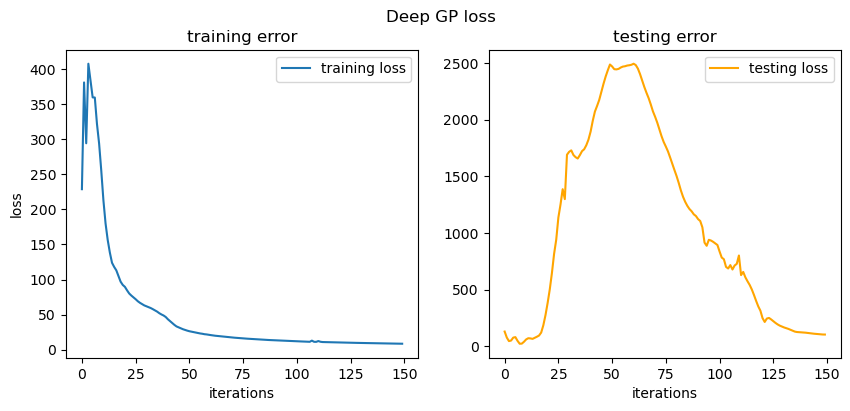

In [10]:
#plot loss log
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Deep GP loss')
axs[0].plot(train_losses, label = 'training loss')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('loss')
axs[0].set_title('training error')
axs[0].legend()

axs[1].set_xlabel('iterations')
axs[1].plot(test_losses, label = 'testing loss', c = 'orange')
axs[1].set_title('testing error')
axs[1].legend()

In [11]:
# Put model & likelihood into eval mode
model_8.eval()
likelihood_8.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_prediction = likelihood_8(model_8(X_train_8))
    train_mean = train_prediction.mean
    test_prediction = likelihood_8(model_8(X_test_8))
    test_mean = test_prediction.mean
    train_lower, train_upper = train_prediction.confidence_region()
    test_lower, test_upper = test_prediction.confidence_region()

#add nan in the middle of testing prediction, use for later plotting
y_pred_train_with_nan = d = np.concatenate((np.array(train_mean[0:train_size])\
    , np.array([np.nan for i in range(test_size)]), np.array(train_mean[train_size:]))) 
y_pred_test = np.array(test_mean)

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


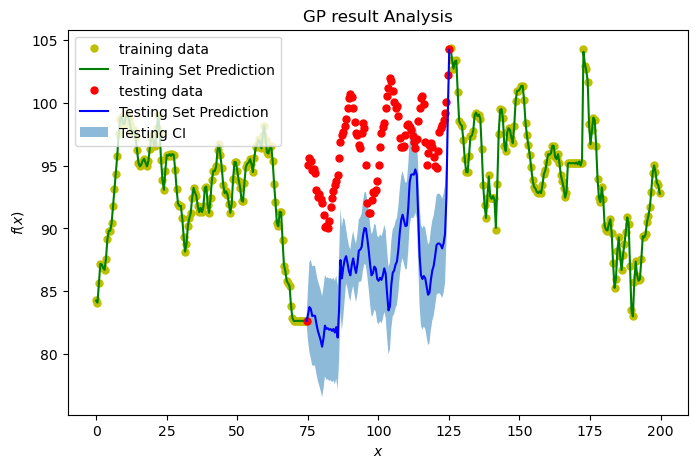

In [12]:
plt.figure(figsize=(8,5))
plt.plot(X_train_with_nan, Y_train_with_nan, 'y.', markersize=10, label='training data') #plot training data
plt.plot(X_train_with_nan, y_pred_train_with_nan, 'g-', label='Training Set Prediction') # plot training prediction
plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data') #plot testing data
plt.plot(X_test, y_pred_test, 'b-', label='Testing Set Prediction') #plot testing prediction
plt.fill_between(X_test, test_lower, test_upper, alpha=0.5, label = 'Testing CI') #add CI

plt.title('GP result Analysis')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()

## 2.9 Deep Model (Periodic + FixedNoiseLikelyhood) But no interpolation

In [14]:
class GPRegressionModel_9(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_9, self).__init__(train_x, train_y, likelihood)

        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        #we are going to warpping below kernel inside the interpolation kernel
        self.base_kernel = gpytorch.kernels.PeriodicKernel()

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())

        # self.covar_module = gpytorch.kernels.ScaleKernel(
        #     gpytorch.kernels.GridInterpolationKernel(
        # self.base_kernel, grid_size=grid_size, num_dims=1
        #     )
        # )

        self.feature_extractor = LargeFeatureExtractor(input_dim=train_x.size(-1))

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        # We're also scaling the features so that they're nice values
        projected_x = self.feature_extractor(x)
        projected_x = projected_x - projected_x.min(0)[0]
        projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

        # The rest of this looks like what we've seen
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood_9 = FixedNoiseGaussianLikelihood(torch.ones(len(X_train_8)) * 0.01)
###likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood.noise_covar.noise = 1
model_9 = GPRegressionModel_9(X_train_8, Y_train_8, likelihood_9)

if torch.cuda.is_available():

    model_9 = model_9.cuda()
    likelihood_9 = likelihood_9.cuda()

In [15]:
training_iterations =  150

start_time = time.time()

# Find optimal model hyperparameters
model_9.train()
likelihood_9.train()

# Use the adam optimizer
optimizer_9 = torch.optim.Adam(model_9.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_9, model_9)

train_losses = []
test_losses = []

for epoch in range(training_iterations):
    #get train loss for this iter
    model_9.train()
    likelihood_9.train()
    optimizer_9.zero_grad()
    train_predition = model_9(X_train_8)
    train_loss = -mll(train_predition, Y_train_8)
    train_losses.append(train_loss)
    train_loss.backward()
    optimizer_9.step()

    #get test loss for this iter
    model_9.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        untrained_pred_dist = likelihood_9(model_9(X_test_8))
        predictive_mean = untrained_pred_dist.mean
        lower, upper = untrained_pred_dist.confidence_region()
        #here we use mse instead of marginal log likelihood because 
        #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
        test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
        test_losses.append(test_mse)

end_time = time.time()  
    

train_losses = [float(i) for i in train_losses]
print('training time for', training_iterations, 'epochs:', end_time - start_time)

training time for 150 epochs: 5.46392297744751


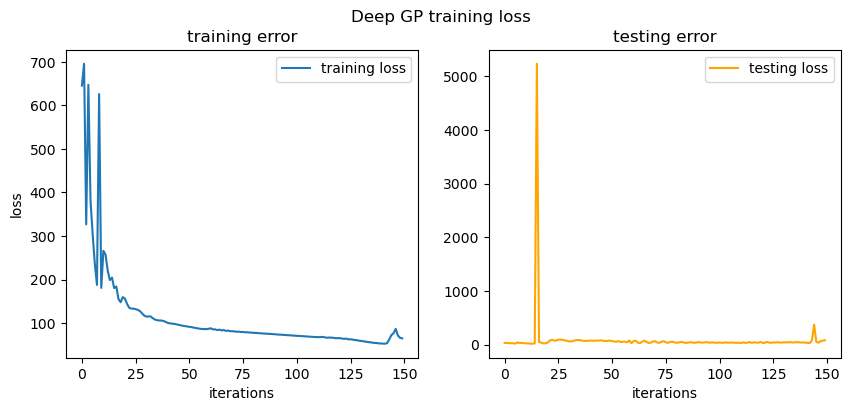

In [16]:
#plot loss log
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Deep GP training loss')
axs[0].plot(train_losses, label = 'training loss')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('loss')
axs[0].set_title('training error')
axs[0].legend()

axs[1].set_xlabel('iterations')
axs[1].plot(test_losses, label = 'testing loss', c = 'orange')
axs[1].set_title('testing error')
axs[1].legend()

In [17]:
# Put model & likelihood into eval mode
model_9.eval()
likelihood_9.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_prediction = likelihood_9(model_9(X_train_8))
    train_mean = train_prediction.mean
    test_prediction = likelihood_9(model_9(X_test_8))
    test_mean = test_prediction.mean
    train_lower, train_upper = train_prediction.confidence_region()
    test_lower, test_upper = test_prediction.confidence_region()

#add nan in the middle of testing prediction, use for later plotting
y_pred_train_with_nan = d = np.concatenate((np.array(train_mean[0:train_size])\
    , np.array([np.nan for i in range(test_size)]), np.array(train_mean[train_size:]))) 
y_pred_test = np.array(test_mean)

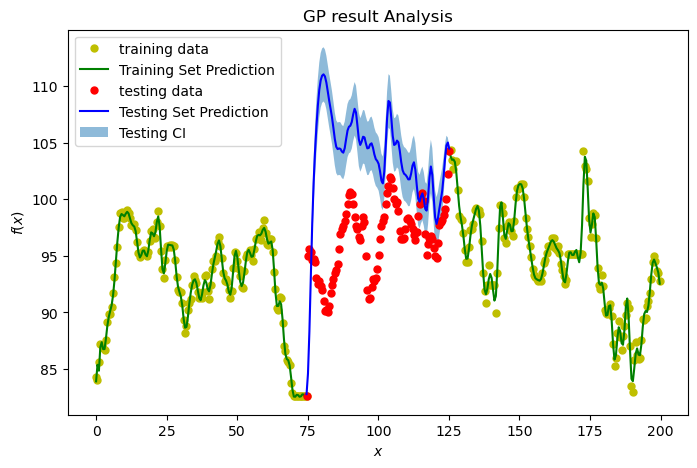

In [18]:
plt.figure(figsize=(8,5))
plt.plot(X_train_with_nan, Y_train_with_nan, 'y.', markersize=10, label='training data') #plot training data
plt.plot(X_train_with_nan, y_pred_train_with_nan, 'g-', label='Training Set Prediction') # plot training prediction
plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data') #plot testing data
plt.plot(X_test, y_pred_test, 'b-', label='Testing Set Prediction') #plot testing prediction
plt.fill_between(X_test, test_lower, test_upper, alpha=0.5, label = 'Testing CI') #add CI

plt.title('GP result Analysis')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()

Strange: when training epoch is 400, the result degenerate

## 2.10 Deep Model (Periodic + RBF + FixedNoiseLikelyhood) Problematic verseion

problem1: covariance kernel with GridInterpolationKernel, cause a problem

In [9]:
class GPRegressionModel_9(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_9, self).__init__(train_x, train_y, likelihood)

        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        #we are going to warpping below kernel inside the interpolation kernel
        self.base_kernel = gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.RBFKernel() 

        self.mean_module = gpytorch.means.ConstantMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
        self.base_kernel, grid_size=grid_size, num_dims=1
            )
        )

        self.feature_extractor = LargeFeatureExtractor(input_dim=train_x.size(-1))

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        # We're also scaling the features so that they're nice values
        projected_x = self.feature_extractor(x)
        projected_x = projected_x - projected_x.min(0)[0]
        projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

        # The rest of this looks like what we've seen
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood_9 = FixedNoiseGaussianLikelihood(torch.ones(len(X_train_8)) * 0.01)
###likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood.noise_covar.noise = 1
model_9 = GPRegressionModel_9(X_train_8, Y_train_8, likelihood_9)

if torch.cuda.is_available():

    model_9 = model_9.cuda()
    likelihood_9 = likelihood_9.cuda()

In [13]:
training_iterations =  300

start_time = time.time()

# Find optimal model hyperparameters
model_9.train()
likelihood_9.train()

# Use the adam optimizer
optimizer_9 = torch.optim.Adam(model_9.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_9, model_9)

train_losses = []

for epoch in range(training_iterations):
    #get train loss for this iter
    model_9.train()
    likelihood_9.train()
    optimizer_9.zero_grad()
    train_predition = model_9(X_train_8)
    train_loss = -mll(train_predition, Y_train_8)
    train_losses.append(train_loss)
    train_loss.backward()
    optimizer_9.step()

end_time = time.time()

train_losses = [float(i) for i in train_losses]
print('training time for', training_iterations, 'epochs:', end_time - start_time)

NameError: name 'model_9' is not defined